# 프로젝트: 뉴스기사 요약해보기

추상적 요약과 추출적 요약

In [1]:
from importlib.metadata import version
import nltk
import tensorflow
import summa
import pandas as pd

print(nltk.__version__)
print(tensorflow.__version__)
print(pd.__version__)
print(version('summa'))

3.6.5
2.6.0
1.3.3
1.2.0


In [430]:
from bs4 import BeautifulSoup 
from nltk.corpus import stopwords
import re
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import AdditiveAttention

from summa.summarizer import summarize

# Step 1. 데이터 수집하기

- 출처: [sunnysai12345/News_Summary](https://github.com/sunnysai12345/News_Summary)

In [3]:
data = pd.read_csv('/aiffel/news_summary_more.csv', encoding='iso-8859-1')
data.sample(10)

,headlines,text
20726,Malaysia suspends $22 billion worth of China-b...,"Malaysian PM Mahathir Mohamad, who is on a fiv..."
2567,"Ex-CBI chief quits IPS, refuses to take role o...",Alok Verma has refused to take charge as Direc...
26816,"Biker jumps over 16 buses, covers more than 19...",American stunt performer Travis Pastrana honou...
33809,I-T Dept issues fresh notice to Chanda Kochhar...,The Income Tax Department has reportedly issue...
61077,Sun Pharma profit falls 59% to Ã¢ÂÂ¹912 crore...,India's largest drugmaker Sun Pharmaceutical o...
84897,Startup to launch 24x7 open self-driving store...,Swedish startup Wheelys is launching a 24x7 op...
91476,"Reebok trolls Nordstrom with a Ã¢ÂÂ¹27,000 sw...",Sportswear brand Reebok has advertised a sweat...
90983,India to sell only electric cars by 2030: Powe...,Power Minister Piyush Goyal on Sunday said Ind...
58543,US man accidentally shoots grandson during tar...,A 68-year-old man accidentally shot his 22-yea...
4179,Let's make positivity viral: PM in 2018's last...,"In the last 'Mann ki Baat' address of 2018, PM..."


- 기사의 본문에 해당되는 text와 headlines 두 가지 열로 구성

- 추상적 요약을 하는 경우에는 text를 본문, headlines를 이미 요약된 데이터로 삼아서 모델 학습
- 추출적 요약을 하는 경우에는 오직 text열만을 사용

# Step 2. 데이터 전처리하기 (추상적 요약)

## 중복 샘플과 NULL 값이 존재하는 샘플 제거

In [28]:
print("전체 데이터의 샘플 수 \t: ", len(data))
print("text 중복 샘플 수 \t: ", len(data['text']) - data['text'].nunique())
print("headlines 중복 샘플 수\t: ", len(data['headlines']) - data['headlines'].nunique())

전체 데이터의 샘플 수 	:  98401
text 중복 샘플 수 	:  41
headlines 중복 샘플 수	:  121


- 다른 기사라도 같은 headline으로 쓰일 수 있기 때문에 headlines 중복은 무시.
- text의 중복은 제거

In [29]:
data.drop_duplicates(subset = ['text'], inplace=True)
print('중복 제거 후 전체 샘플 수 :', (len(data)))

중복 제거 후 전체 샘플 수 : 98360


In [30]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


- Null 부존재 확인

## 텍스트 정규화 및 불용어 제거

- 불용어는 자연어 처리 효율을 위해 본문(text)에서는 제거하되, 헤드라인은 그 특성상 길이도 짧고 불용어 사용이 잦으므로 불용어를 제거하지 않고 진행한다. 
- [정규화 사전 출처](https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python)

In [36]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [40]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (headlines)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [45]:
clean_text = []

clean_text = data['text'].apply(lambda x: preprocess_sentence(x, remove_stopwords=True))

In [47]:
clean_headlines = []

for i in data["headlines"]:
    clean_headlines.append(preprocess_sentence(i, remove_stopwords=False))

In [74]:
type(clean_text), type(clean_headlines)

(pandas.core.series.Series, list)

- 전처리 결과 확인

In [63]:
# 인덱스를 리셋하여 해당 인덱스 전후 차이를 확인
data.reset_index(inplace=True, drop=True)

In [58]:
print(data.loc[91476, 'headlines'])
print(clean_headlines[91476])

Why does popcorn make the 'pop' sound?
why does popcorn make the pop sound


In [67]:
print(data.loc[91435, 'headlines'])
print(clean_headlines[91435])

Reebok trolls Nordstrom with a Ã¢ÂÂ¹27,000 sweat-soaked T-shirt 
reebok trolls nordstrom with sweat soaked shirt


In [76]:
clean_text.reset_index(drop=True, inplace=True)

In [77]:
print(data.loc[91476, 'text'], "\n")
print(clean_text[91476])

The 'pop' sound of a popcorn is due to pressurised water vapour rapidly escaping from the interior. Inside the protective covering, each popcorn kernel comprises starchy endosperm and water. As it is cooked, the water inside heats up, creates steam and expands. The water and steam eventually create enough internal pressure to break the covering and make the kernel pop. 

pop sound popcorn due pressurised water vapour rapidly escaping interior inside protective covering popcorn kernel comprises starchy endosperm water cooked water inside heats creates steam expands water steam eventually create enough internal pressure break covering make kernel pop


- 전처리 후 빈 샘플 확인

In [82]:
clean_headlines.count(""), clean_text.isnull().sum()

(0, 0)

In [84]:
data['text'] = clean_text
data['headlines'] = clean_headlines

data.head()

,headlines,text
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...


In [88]:
data.replace('', np.nan).isnull().sum()

headlines    0
text         0
dtype: int64

## 샘플 최대 길이 제한

텍스트의 최소 길이 	: 1
텍스트의 최대 길이 	: 60
텍스트의 평균 길이 	: 35.09968483123221
헤드라인의 최소 길이 	: 1
헤드라인의 최대 길이 	: 16
헤드라인의 평균 길이 	: 9.299532330215534


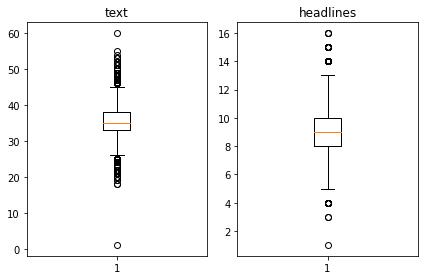

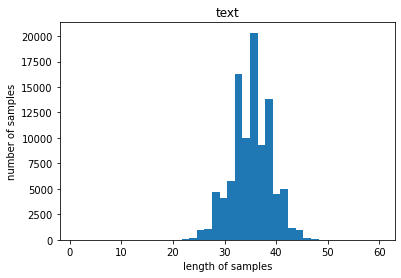

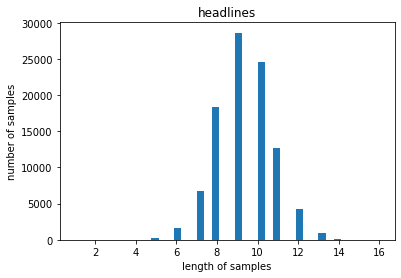

In [96]:
# 길이 분포 출력
def get_len_graph(data):
    text_len = [len(s.split()) for s in data['text']]
    headlines_len = [len(s.split()) for s in data['headlines']]

    print('텍스트의 최소 길이 \t: {}'.format(np.min(text_len)))
    print('텍스트의 최대 길이 \t: {}'.format(np.max(text_len)))
    print('텍스트의 평균 길이 \t: {}'.format(np.mean(text_len)))
    print('헤드라인의 최소 길이 \t: {}'.format(np.min(headlines_len)))
    print('헤드라인의 최대 길이 \t: {}'.format(np.max(headlines_len)))
    print('헤드라인의 평균 길이 \t: {}'.format(np.mean(headlines_len)))

    plt.subplot(1,2,1)
    plt.boxplot(text_len)
    plt.title('text')
    plt.subplot(1,2,2)
    plt.boxplot(headlines_len)
    plt.title('headlines')
    plt.tight_layout()
    plt.show()

    plt.title('text')
    plt.hist(text_len, bins = 40)
    plt.xlabel('length of samples')
    plt.ylabel('number of samples')
    plt.show()

    plt.title('headlines')
    plt.hist(headlines_len, bins = 40)
    plt.xlabel('length of samples')
    plt.ylabel('number of samples')
    plt.show()

get_len_graph(data)

### Outlier 확인 (짧은 길이의 샘플)

In [101]:
data[data['text'].str.split().str.len() < 19]

,headlines,text
52,headlines,text
19018,as an actor you are always lonely shahid kapoor,shahid kapoor said actor one always lonely add...
70244,how much will iphone cost in other countries,apple newly launched iphone edge edge display ...


In [107]:
def show_sample(idx):
    print(data.loc[idx, 'headlines'])
    print("="*len(data.loc[idx, 'headlines']))
    print(data.loc[idx, 'text'])
    
show_sample(70244)

how much will iphone cost in other countries
apple newly launched iphone edge edge display face recognition wireless charging technology available russia italy cost uk priced


In [108]:
show_sample(19018)

as an actor you are always lonely shahid kapoor
shahid kapoor said actor one always lonely adding always spotlight people see lonely actors emote inside throw said


In [102]:
data[data['headlines'].str.split().str.len() < 4]

,headlines,text
52,headlines,text
729,angola decriminalises homosexuality,african nation angola decriminalised homosexua...
26211,what is friggatriskaidekaphobia,friggatriskaidekaphobia person irrational fear...


In [109]:
show_sample(729)

angola decriminalises homosexuality
african nation angola decriminalised homosexuality parliament removed vices nature provision government also banned discrimination people basis sexual orientation changes come angola parliament adopted first new penal code since gained independence portugal removed provision


In [112]:
show_sample(26211)

what is friggatriskaidekaphobia
friggatriskaidekaphobia person irrational fear month th day falling friday long standing legend claims day date unlucky number considered unlucky many cultures least one friday th every year maximum three


- 52번 행의 값을 제외하면 괜찮아 보임.
- 52번 행 삭제

In [123]:
data.drop(52, inplace=True)

In [124]:
data[data['headlines'].str.split().str.len() < 4]

,headlines,text
729,angola decriminalises homosexuality,african nation angola decriminalised homosexua...
26211,what is friggatriskaidekaphobia,friggatriskaidekaphobia person irrational fear...


In [126]:
data.loc[51:53]

,headlines,text
51,boeing sales cross bn for st time in its yr hi...,us based boeing wednesday reported annual sale...
53,oneplus named bestselling premium smartphone b...,oneplus emerged india best selling premium sma...


- 인덱스 리셋

In [127]:
data.reset_index(inplace=True, drop=True)
data.loc[51:53]

,headlines,text
51,boeing sales cross bn for st time in its yr hi...,us based boeing wednesday reported annual sale...
52,oneplus named bestselling premium smartphone b...,oneplus emerged india best selling premium sma...
53,can never look at female body even if naked in...,filmmaker pooja bhatt talking presentation wom...


### Outlier  확인 (긴 길이의 샘플)

- 데이터 내 일반적이지 않게 긴 샘플로 인해 대다수의 데이터에 필요 이상의 긴 패딩이 들어가 모델 성능을 저하시키는 문제가 발생할 수 있다.

- 적당한 최대 길이를 선정하여 그보다 긴 샘플을 제외한다.

In [134]:
text_max_len = 45
headlines_max_len = 13

In [162]:
def check_above_thres(max_len, column):
    num_outlier = len(data[data[column].str.split().str.len() > max_len])
    print(f'길이 {max_len} 초과의 샘플 수  : {num_outlier}')
    print(f'길이 {max_len} 이하의 샘플 비율: {100 * (1 - num_outlier / len(data)):.2f}%')

- 헤드라인의 경우 13을 초과 하는 경우 Outlier로 계산

In [163]:
check_above_thres(headlines_max_len, 'headlines')

길이 13 초과의 샘플 수  : 180
길이 13 이하의 샘플 비율: 99.82%


- 본문의 경우 45를 초과 하는 경우 Outlier로 계산

In [164]:
check_above_thres(text_max_len, 'text')

길이 45 초과의 샘플 수  : 317
길이 45 이하의 샘플 비율: 99.68%


- 헤드라인, 본문의 아웃라이어 중복 여부 확인

In [201]:
headlines_out = data[data['headlines'].str.split().str.len() > headlines_max_len].index
text_out = data[data['text'].str.split().str.len() > text_max_len].index

len(headlines_out.intersection(text_out))

0

- 중복되지 않는 각 아웃라이어를 제외하면 총 97,862개의 데이터가 남을 것으로 예상

In [203]:
len(data) - 180 - 317

97862

In [200]:
headlines_out = data[data['headlines'].str.split().str.len() <= headlines_max_len].index
text_out = data[data['text'].str.split().str.len() <= text_max_len].index

len(headlines_out.intersection(text_out))

97862

In [205]:
data = data[((data['headlines'].str.split().str.len() <= headlines_max_len) &
             (data['text'].str.split().str.len() <= text_max_len))]

data

,headlines,text
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...
...,...,...
98354,crpf jawan axed to death by maoists in chhatti...,crpf jawan tuesday axed death sharp edged weap...
98355,first song from sonakshi sinha noor titled uff...,uff yeh first song sonakshi sinha starrer upco...
98356,the matrix film to get reboot reports,according reports new version science fiction ...
98357,snoop dogg aims gun at clown dressed as trump ...,new music video shows rapper snoop dogg aiming...


텍스트의 최소 길이 	: 18
텍스트의 최대 길이 	: 45
텍스트의 평균 길이 	: 35.063354519629684
헤드라인의 최소 길이 	: 3
헤드라인의 최대 길이 	: 13
헤드라인의 평균 길이 	: 9.289959330485786


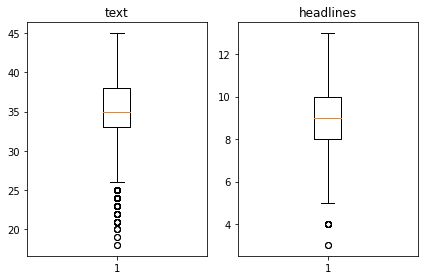

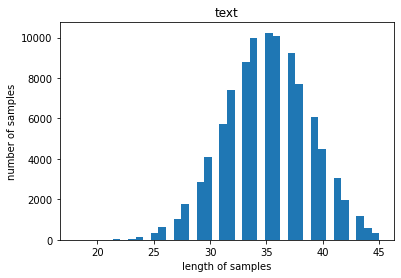

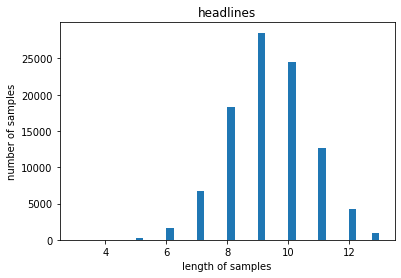

In [343]:
get_len_graph(data)

## 시작 및 종료 토큰 추가

In [219]:
data.loc[:, 'decoder_input'] = 'sostoken ' + data['headlines']
data.loc[:, 'decoder_target'] = data['headlines'] + ' eostoken'

data

/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...,sostoken have known hirani for yrs what if met...,have known hirani for yrs what if metoo claims...
...,...,...,...,...
98354,crpf jawan axed to death by maoists in chhatti...,crpf jawan tuesday axed death sharp edged weap...,sostoken crpf jawan axed to death by maoists i...,crpf jawan axed to death by maoists in chhatti...
98355,first song from sonakshi sinha noor titled uff...,uff yeh first song sonakshi sinha starrer upco...,sostoken first song from sonakshi sinha noor t...,first song from sonakshi sinha noor titled uff...
98356,the matrix film to get reboot reports,according reports new version science fiction ...,sostoken the matrix film to get reboot reports,the matrix film to get reboot reports eostoken
98357,snoop dogg aims gun at clown dressed as trump ...,new music video shows rapper snoop dogg aiming...,sostoken snoop dogg aims gun at clown dressed ...,snoop dogg aims gun at clown dressed as trump ...


In [220]:
data.loc[0, 'decoder_target']

'upgrad learner switches to career in ml al with salary hike eostoken'

## 데이터 나누기

- 데이터 샘플 순서를 동일하게 섞어서 각 인코더의 입력, 디코더의 입력과 레이블로 나누기

In [323]:
encoder_input = np.array(data.sample(frac=1, random_state=33)['text'])
decoder_input = np.array(data.sample(frac=1, random_state=33)['decoder_input'])
decoder_target = np.array(data.sample(frac=1, random_state=33)['decoder_target'])

encoder_input.shape, decoder_input.shape, decoder_target.shape

((97862,), (97862,), (97862,))

- 8:2 비율로 Train, Validation Set으로 분리

In [338]:
n_of_val = int(len(data)*0.2)
print('validation 데이터의 수 :', n_of_val)

validation 데이터의 수 : 19572


In [363]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_val = encoder_input[-n_of_val:]
decoder_input_val = decoder_input[-n_of_val:]
decoder_target_val = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('검증 데이터의 개수 :', len(encoder_input_val))
print('검증 레이블의 개수 :', len(decoder_input_val))

훈련 데이터의 개수 : 78290
훈련 레이블의 개수 : 78290
검증 데이터의 개수 : 19572
검증 레이블의 개수 : 19572


## 단어 집합(vocabulary) 만들기 및 정수 인코딩

### Encoder Input

- 토크나이저를 이용하여 단어 집합 생성

In [364]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [378]:
def vocab_analysis(tokenizer, threshold):
    total_cnt = len(tokenizer.word_index) # 단어의 수
    rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
    total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
    rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

    # 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
    for key, value in tokenizer.word_counts.items():
        total_freq = total_freq + value

        # 단어의 등장 빈도수가 threshold보다 작으면
        if(value < threshold):
            rare_cnt = rare_cnt + 1
            rare_freq = rare_freq + value

    print('단어 집합(vocabulary)의 크기 :', total_cnt)
    print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
    print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기: %s'%(total_cnt - rare_cnt))
    print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
    print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

In [381]:
vocab_analysis(src_tokenizer, 8)

단어 집합(vocabulary)의 크기 : 69409
등장 빈도가 7번 이하인 희귀 단어의 수: 48730
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기: 20679
단어 집합에서 희귀 단어의 비율: 70.20703366998517
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.8632789653055117


- 약 6만 9천여 개의 단어 중 2만 개의 단어로 집합의 크기를 제한.
- 약 96% 이상 등장 빈도를 갖는 단어들로 단어 집합 구성.

In [366]:
src_vocab = 20000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 20,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

- 정수 인코딩

In [367]:
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train)
encoder_input_val = src_tokenizer.texts_to_sequences(encoder_input_val)

# 샘플 출력
print(encoder_input_train[:3])

[[239, 429, 466, 3250, 1953, 136, 10948, 61, 81, 69, 574, 160, 60, 6323, 154, 112, 3352, 3778, 2403, 9, 1330, 85, 10, 985, 77, 7220, 24, 773, 1797, 1197], [160, 60, 9, 1975, 640, 66, 717, 3530, 177, 6791, 255, 15942, 971, 156, 109, 66, 432, 1975, 3751, 3317, 1408, 65, 1899, 255, 37, 6, 159, 5865, 1408, 3489], [11513, 214, 45, 150, 15, 114, 47, 88, 1, 1016, 748, 135, 1008, 7408, 1066, 320, 1651, 887, 2842, 3653, 9264, 47, 4, 2, 420, 1968, 8210, 232, 197, 6479, 288, 12153, 5796, 1968, 752]]


### Decoder Input & Target

- 집합 생성

In [382]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [391]:
vocab_analysis(tar_tokenizer, 9)

단어 집합(vocabulary)의 크기 : 30071
등장 빈도가 8번 이하인 희귀 단어의 수: 21957
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기: 8114
단어 집합에서 희귀 단어의 비율: 73.01719264407569
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 6.609342342387069


- 약 3만여 개의 단어 중 8천 개의 단어로 집합의 크기를 제한.
- 약 93% 이상 등장 빈도를 갖는 단어들로 단어 집합 구성.

In [393]:
tar_vocab = 8000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

- 정수 인코딩

In [396]:
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_val = tar_tokenizer.texts_to_sequences(decoder_input_val)
decoder_target_val = tar_tokenizer.texts_to_sequences(decoder_target_val)

# 변환 결과 확인
print('input')
print('input ',decoder_input_train[:5])
print('='*50)
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 337, 321, 2482, 1922, 4, 25], [1, 427, 641, 11, 75, 243, 122, 3108, 260, 12, 5409], [1, 1364, 2524, 4, 346, 860, 19, 431, 38], [1, 427, 125, 5, 688, 40, 7, 6, 521], [1, 8, 2905, 9, 2433, 12, 4255, 4989, 478, 4, 1285]]
target
decoder  [[337, 321, 2482, 1922, 4, 25, 2], [427, 641, 11, 75, 243, 122, 3108, 260, 12, 5409, 2], [1364, 2524, 4, 346, 860, 19, 431, 38, 2], [427, 125, 5, 688, 40, 7, 6, 521, 2], [8, 2905, 9, 2433, 12, 4255, 4989, 478, 4, 1285, 2]]


## 빈 샘플 제거

- 인코딩 후 빈도수가 낮은 단어로만 구성되어 빈 샘플이 있는지 확인하여 제거

In [397]:
print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('검증 데이터의 개수 :', len(encoder_input_val))
print('검증 레이블의 개수 :', len(decoder_input_val))

훈련 데이터의 개수 : 78290
훈련 레이블의 개수 : 78290
검증 데이터의 개수 : 19572
검증 레이블의 개수 : 19572


In [399]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_val = [index for index, sentence in enumerate(decoder_input_val) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_val))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_val = [sentence for index, sentence in enumerate(encoder_input_val) if index not in drop_val]
decoder_input_val = [sentence for index, sentence in enumerate(decoder_input_val) if index not in drop_val]
decoder_target_val = [sentence for index, sentence in enumerate(decoder_target_val) if index not in drop_val]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('검증 데이터의 개수 :', len(encoder_input_val))
print('검증 레이블의 개수 :', len(decoder_input_val))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 78290
훈련 레이블의 개수 : 78290
검증 데이터의 개수 : 19572
검증 레이블의 개수 : 19572


## 패딩

- 최대 길이에 맞추어 패딩

In [401]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_val = pad_sequences(encoder_input_val, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_val = pad_sequences(decoder_input_val, maxlen=headlines_max_len, padding='post')
decoder_target_val = pad_sequences(decoder_target_val, maxlen=headlines_max_len, padding='post')

# Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)

실습 내용을 참고하여 어텐션 메커니즘을 사용한 seq2seq를 설계.

## Modeling

In [404]:
'''
Encoder
'''
# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout = 0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout = 0.4)
encoder_output3, state_h3, state_c3 = encoder_lstm3(encoder_output2)

'''
Decoder
'''
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h3, state_c3])


'''
Attention
'''
# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_output3])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])


# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 45)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 45, 128)      2560000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 45, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

## Training

In [416]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_val, decoder_input_val], decoder_target_val), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
306/306 [==============================] - 36s 100ms/step - loss: 4.5076 - val_loss: 4.2905
Epoch 2/50
306/306 [==============================] - 31s 101ms/step - loss: 4.1697 - val_loss: 4.0315
Epoch 3/50
306/306 [==============================] - 32s 104ms/step - loss: 3.9314 - val_loss: 3.8639
Epoch 4/50
306/306 [==============================] - 33s 109ms/step - loss: 3.7462 - val_loss: 3.7354
Epoch 5/50
306/306 [==============================] - 32s 106ms/step - loss: 3.5915 - val_loss: 3.6378
Epoch 6/50
306/306 [==============================] - 33s 107ms/step - loss: 3.4592 - val_loss: 3.5623
Epoch 7/50
306/306 [==============================] - 32s 106ms/step - loss: 3.3439 - val_loss: 3.4915
Epoch 8/50
306/306 [==============================] - 33s 107ms/step - loss: 3.2445 - val_loss: 3.4439
Epoch 9/50
306/306 [==============================] - 33s 107ms/step - loss: 3.1556 - val_loss: 3.4029
Epoch 10/50
306/306 [==============================] - 33s 107ms/step - l

- 훈련 과정 시각화

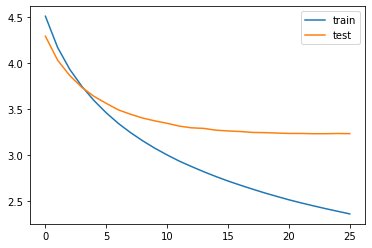

In [417]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## Inference Modeling

- 사전 준비

In [418]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

- 모델링

In [419]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_output3, state_h3, state_c3])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [420]:
encoder_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 45)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 45, 128)           2560000   
_________________________________________________________________
lstm (LSTM)                  [(None, 45, 256), (None,  394240    
_________________________________________________________________
lstm_1 (LSTM)                [(None, 45, 256), (None,  525312    
_________________________________________________________________
lstm_2 (LSTM)                [(None, 45, 256), (None,  525312    
Total params: 4,004,864
Trainable params: 4,004,864
Non-trainable params: 0
_________________________________________________________________


In [421]:
decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 128)    1024000     input_2[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 256)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 256)]        0                                            
____________________________________________________________________________________________

- 시퀀스 완성 함수

In [422]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

# Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)

- 원래의 요약문(headlines 열)과 학습을 통해 얻은 추상적 요약의 결과 비교

- 실제 헤드라인과 추론 결과 비교를 위한 시퀀스 투 텍스트 함수

In [423]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2headlines(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0 and i!=tar_word_to_index['sostoken'] and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [426]:
for i in range(10):
    print("원문 :", seq2text(encoder_input_val[i]))
    print("실제 요약 :", seq2headlines(decoder_input_val[i]))
    print("예측 요약 :", decode_sequence(encoder_input_val[i].reshape(1, text_max_len)), "\n \n")

원문 : railway protection force personnel mumbai saved five year old girl falling gap platform coach slipped train begun moving suddenly child boarding according reports incident captured cctv later passengers also rushed help personnel 
실제 요약 : mumbai personnel saves child who while boarding 
예측 요약 :  mumbai railway station saves yr old girl from falling 
 

원문 : reacting late actress sridevi win th national film awards family said super actor super wife super mom husband boney kapoor daughters janhvi khushi thanked government jury members fans celebrating achievements sridevi received national award best actress mom posthumously 
실제 요약 : sridevi was super wife super mom says family on award win 
예측 요약 :  sridevi was the best actress in sridevi demise 
 

원문 : union finance minister arun jaitley wednesday said lok sabha process almost added government making attempts implement gst july moving towards time shadow economy still seeing cash transactions added 
실제 요약 : process is almost ove

In [428]:
def compare_headlines(idx):
    print("원문 :", seq2text(encoder_input_val[idx]))
    print("실제 요약 :", seq2headlines(decoder_input_val[idx]))
    print("예측 요약 :", decode_sequence(encoder_input_val[idx].reshape(1, text_max_len)))

In [429]:
compare_headlines(0)

원문 : railway protection force personnel mumbai saved five year old girl falling gap platform coach slipped train begun moving suddenly child boarding according reports incident captured cctv later passengers also rushed help personnel 
실제 요약 : mumbai personnel saves child who while boarding 
예측 요약 :  mumbai railway station saves yr old girl from falling


# Step 5. Summa을 이용해서 추출적 요약해보기

- Summa의 summarize를 사용하여 추출적 요약 적용.

In [431]:
!pip list | grep summa

summa                         1.2.0


In [473]:
def compare2summa(idx):
    compare_headlines(idx)
    print("Summa 요약:", summarize(data_summ.loc[idx, "text"], words=headlines_max_len))

In [468]:
data_summ = pd.read_csv('/aiffel/news_summary_more.csv', encoding='iso-8859-1')
data_summ = data_summ.loc[:10]
data_summ

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...
5,Rahat Fateh Ali Khan denies getting notice for...,Pakistani singer Rahat Fateh Ali Khan has deni...
6,"India get all out for 92, their lowest ODI tot...",India recorded their lowest ODI total in New Z...
7,Govt directs Alok Verma to join work 1 day bef...,Weeks after ex-CBI Director Alok Verma told th...
8,Called PM Modi 'sir' 10 times to satisfy his e...,Andhra Pradesh CM N Chandrababu Naidu has said...
9,"Cong wins Ramgarh bypoll in Rajasthan, takes t...",Congress candidate Shafia Zubair won the Ramga...


In [474]:
compare2summa(0)

원문 : railway protection force personnel mumbai saved five year old girl falling gap platform coach slipped train begun moving suddenly child boarding according reports incident captured cctv later passengers also rushed help personnel 
실제 요약 : mumbai personnel saves child who while boarding 
예측 요약 :  mumbai railway station saves yr old girl from falling
Summa 요약: upGrad's Online Power Learning has powered 3 lakh+ careers.


In [ ]:
data_summ = pd.read_csv('/aiffel/news_summary_more.csv', encoding='iso-8859-1')
data_summ.drop_duplicates(subset = ['text'], inplace=True)
data_summ

In [511]:
data_summ

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...
5,Rahat Fateh Ali Khan denies getting notice for...,Pakistani singer Rahat Fateh Ali Khan has deni...
6,"India get all out for 92, their lowest ODI tot...",India recorded their lowest ODI total in New Z...
7,Govt directs Alok Verma to join work 1 day bef...,Weeks after ex-CBI Director Alok Verma told th...
8,Called PM Modi 'sir' 10 times to satisfy his e...,Andhra Pradesh CM N Chandrababu Naidu has said...
9,"Cong wins Ramgarh bypoll in Rajasthan, takes t...",Congress candidate Shafia Zubair won the Ramga...


In [507]:
data_summ

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...
5,Rahat Fateh Ali Khan denies getting notice for...,Pakistani singer Rahat Fateh Ali Khan has deni...
6,"India get all out for 92, their lowest ODI tot...",India recorded their lowest ODI total in New Z...
7,Govt directs Alok Verma to join work 1 day bef...,Weeks after ex-CBI Director Alok Verma told th...
8,Called PM Modi 'sir' 10 times to satisfy his e...,Andhra Pradesh CM N Chandrababu Naidu has said...
9,"Cong wins Ramgarh bypoll in Rajasthan, takes t...",Congress candidate Shafia Zubair won the Ramga...


In [490]:
condition = data['headlines'].str.contains(sentence[0], case=False)

In [510]:
data_summ[data['headlines'].str.contains('platform', case=False)]

/tmp/ipykernel_77/978734016.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_summ[data['headlines'].str.contains('platform', case=False)]


,headlines,text


In [496]:
if data['headlines'].str.contains('railway', case=False):
    print()

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [491]:
data_summ[condition]

/tmp/ipykernel_77/950845103.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_summ[condition]


,headlines,text


In [ ]:
condition = 
for word in sentence:
    condition = data['headlines'].str.contains(sentence[0], case=False)

In [469]:
data_summ.loc[0, "text"]

"Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers."

In [472]:
summarize(data_summ.loc[0, "text"], words=headlines_max_len)

"upGrad's Online Power Learning has powered 3 lakh+ careers."

In [ ]:
headlines_max_len = 13

---

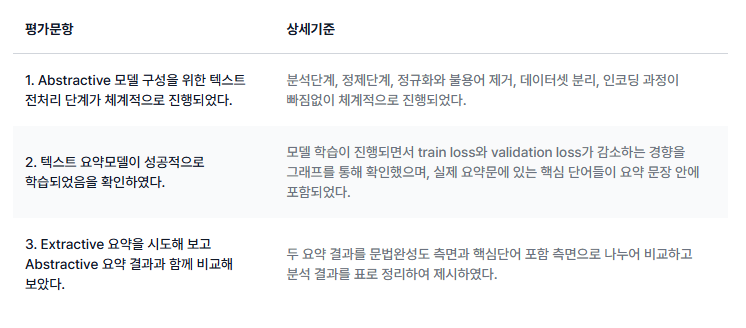